## Chapter 2. Neural Networks
### Intro to neural networks
* Information occurs mathematically, over simple elements called **neurons**
* Neurons are connected and exchange signals (i.e. numbers) between each other through links
* Each link has a **weight**, determining how information is processed as it passes through
* Each neuron has an internal state, determined by all the incoming links
* Each neuron has an **activation function** which determines the output signal as a function of its state

The **architecture** of a neural network defines what type of connectivity the units have (i.e. feedforward, recurrent, multi-
or single-layered, etc.), the number of layers and of neurons within each layer.
The **learning** describes how the network adapt and improves; common tools are _gradient descent_ and _backpropagation_.

### Intro to neurons
Mathematically, a neuron is defined as:
```
y = f(sum(x[:] * w[:]) + b)
```
where ```x``` represents the inputs, and ```w``` represents the weights. ```b``` represents the _bias_ and its input is 
always 1.

### Intro to layers
In a neural network, the input layer represents the dataset and the initial conditions: if the net deals with grayscale 
images, the units in the first layer will represent the pixel intensity. The output layer can have more than one neuron:
usually we find one unit per possible answer/class.

### Multi-layer networks
Single layer networks can only classify linearly separable classes, but by adding **hidden layers** we can surpass this
limitation. Another condition for multi-layer network to classify linearly-inseparable classes is that their **activation
function must not be linear**.

### Different types of activation function
The most common activation functions are the following:
* ```f(a) = a``` - **identity function**
* ```f(a) = [1 if a >= 0, otherwise 0]``` - **threshold activity function**
* ```f(a) = 1 / (1 + exp(-a))``` - **logistic function**, or **logistic sigmoid** (0, 1)
* ```f(a) = 2 / (1 + exp(-a)) = (1 - exp(-a)) / (1 + exp(-a))``` - **bipolar sigmoid** (-1, 1)
* ```f(a) = (exp(a)-exp(-a)) / (exp(a) + exp(-a)) = (1 - exp(-2 * a)) / (1 + exp(-2 * a))``` - **hyperbolic tangent**, tanh (-1, 1)
* ``` f(a) = [a if a >= 0, otherwise 0]``` - **rectified linear unit**, **ReLU** (0, Inf)

### Example
Let's build a very simple net, one hidden layer with two neurons, and single input and output neurons. It will support
the idea that under the _Universal Approximation Theorem_ any continuous function on compact subsets of Rn can be 
approximated by a neural network with at least one hidden layer.

The step function starts at -5.0 and ends at 5.0


C:\Users\Luca\Anaconda3\envs\py37ML2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
C:\Users\Luca\Anaconda3\envs\py37ML2\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


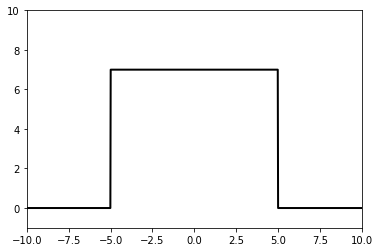

In [2]:
import matplotlib.pyplot as plt
import numpy as np

weight_value = 1000

bias_value_1 = 5000

bias_value_2 = -5000

plt.axis([-10, 10, -1, 10])

print("The step function starts at {0} and ends at {1}".format(-bias_value_1 / weight_value, -bias_value_2 / weight_value))

inputs = np.arange(-10, 10, 0.01)
outputs = list()

for x in inputs:
    y1 = 1.0 / (1.0 + np.exp(-weight_value * x - bias_value_1))
    y2 = 1.0 / (1.0 + np.exp(-weight_value * x - bias_value_2))
    
    w = 7
    
    y = y1 * w - y2 * w
    
    outputs.append(y)
plt.plot(inputs, outputs, lw=2, color='black')
plt.show(block=False)

##### Pyplot backends and settings
Importing ```matplotlib``` and calling the method ```matplotlib.use()``` allows to change pyplot backend.
* **default** DON'T KNOW 
* **'WebAgg'** opens a new browser tab, interactive
* **'Qt5Agg'** new window, interactive (use ```plt.show(block=False)```!!!)

Beware: after setting the backend to ```Qt5Agg``` (or any interactive one), to have inline plots in the notebook again
the Jupyter kernel must be restarted before disabling the ```matplotlib.use()``` call.

### Training neural networks
We will now explore how the training procedure works on a very simple, 1-layer network using an algorithm called
**gradient descent**, then extending the example to a deep forward network using **backpropagation**. During training, we
use these tools with the aim of decreasing the network prediction error as much as possible. It is a minima finding problem.

### Linear regression
In vector notation, the output of a linear regression is a single value, ```y```, and is equal to the dot product of the
input values ```x``` and the weights ```w```. Linear regression **is a special case of a neural network** with a single
unit and identity activation function. 

Gradient descent works as follows:
1. Initialize the weights ```w``` with random values
2. Repeat:
    * Compute the MSE for all the samples of the training set (```(sum(x * w - t) ^ 2) / n```)
    * Compute the derivative of the MSE for each weight, update the weights to minimize it, until MSE is below threshold
    
The learning rate defines the ratio by which the weight adjusts as new data arrives. 

### Logistic regression
Same as above, but with a different activation function (logistic sigmoid activation).

### Backpropagation
For a 1-layer network, updating the weights using gradient descent is straightforward since we can compare the output
with the target and update the weights. In multi-layer networks, we could only do this for the weights that connect
the the final hidden layer to the output layer, because we don't have target values for the intermediate representations.

In this case, what we do is calculate the error in the final hidden layer and estimate what it would have been in the 
previous layer. Then, we propagate the error back from the last layer to the first.

### Code example: net for the XOR function
XOR is a linearly inseparable function, so we will use it to show a net with a hidden layer. 

In [ ]:
from matplotlib.colors import ListedColormap

# noinspection PyShadowingNames
def tanh(x: float):
    return (1.0 - np.exp(-2 * x)) / (1.0 + np.exp(-2 * x))

# noinspection PyShadowingNames
def tanh_deriv(x: float):
    return (1 + tanh(x)) * (1 - tanh(x))

# noinspection PyPep8Naming,PyShadowingNames,PyMethodMayBeStatic
class NeuralNetwork:
    """
    NeuralNetwork represents a simple feedforward network, consisting of an architecture represented by an array whose 
    length defines the number of layers and the elements the number of units in each layer. Implements methods to fit the
    data, to make a prediction and to plot the results.
    """
    def __init__(self, net_arch: list):
        """
        :param net_arch: Architecture of the net, as an array of number of units, with each element representing a layer
        :type net_arch: list 
        :rtype: object
        """
        self.activation_func = tanh  # The function used by each neuron to determine its output as a function of its inputs
        self.activation_deriv = tanh_deriv  # Derivative of the activation function, used for gradient descent during backpropagation
        self.layers = len(net_arch)  # number of layers
        self.steps_per_epoch = 1000
        self.net_arch = net_arch
        
        # Init weights to random values. This will be an array containing an array for each layer but the last (which 
        # doesn't connect to anything, strictly speaking, it just outputs the answer; each inner array contains
        # one value per connection per neuron (with every layer including a bias unit of constant input 1, except for 
        # the last layer), i.e. if we have an architecture of [2, 2, 1], self.weights will be an array of length 2 containing
        # a first array of length 6 (2 units connected with 2 units = 4 synapses + 1 bias connected with 2 units in first
        # layer = 2 == 6) and a second array of length 3 (2 units connected with 1 unit = 2 + 1 bias connected with 1 unit
        # in last layer = 1 == 3). 
        self.weights = []
        for layer in range(len(net_arch) - 1):
            w = 2 * np.random.rand(net_arch[layer] + 1, net_arch[layer + 1]) - 1
            self.weights.append(w)
            
    def fit(self, data, labels, learning_rate: float = 0.1, epochs: int = 10, verbose: bool = False):
        # bias units to the input layer. The input layer contains the input submitted to the net i.e. a pair of bools for
        # our XOR() learning. We add the bias unit, which is just a leading 1.  
        ones = np.ones((1, data.shape[0]))
        Z = np.concatenate((ones.T, data), axis=1)
        if verbose:
            print("Z:\n{}".format(Z))
        training = epochs * self.steps_per_epoch
        if verbose:
            print('total training steps: {}'.format(training))
            print("data:\n{}\nshape:{}".format(data, data.shape))
            print("labels:\n{}\n".format(labels))
            print("bias unit(s) being added, data shape: {}".format(data.shape[0]))
        for k in range(training):
            if k % self.steps_per_epoch == 0:
                print('\n\nepochs: {}'.format(k / self.steps_per_epoch))
                for s in data:
                    print(s, nn.predict(s))
            
            # For the current iteration, select a random input pair to give to the net.
            sample = np.random.randint(data.shape[0])
            y = [Z[sample]]
            if k % self.steps_per_epoch == 0 and verbose:
                print("y before training of epoch {}:\n{}".format(k / self.steps_per_epoch, y))
            
            # Beginning with the input layer, calculate the activation for each unit. This means that we first iterate
            # through the layers (except for the final, which does not need a bias unit input), we calculate the activation
            # value for each neuron given the appropriate weight, we then use the activation function and "transmit" the 
            # information by storing it. This is obtained by computing the dot product between the weights and the units
            # values, then applying the activation function to the resulting vector.
            for i in range(len(self.weights) - 1):
                activation = np.dot(y[i], self.weights[i])
                if k % self.steps_per_epoch == 0 and verbose:
                    print(self.weights[i].shape, y[i].shape)
                activation_f = self.activation_func(activation)
                activation_f = np.concatenate((np.ones(1), np.array(activation_f)))
                y.append(activation_f)
                if k % self.steps_per_epoch == 0 and verbose:
                    print("values transmitted by layer {}:\n{}".format(i, activation_f))
                
            # Same thing for the final layer, just without adding a bias unit to it.
            activation = np.dot(y[-1], self.weights[-1])
            activation_f = self.activation_func(activation)
            y.append(activation_f)
            if k % self.steps_per_epoch == 0 and verbose:
                print("y after last layer:\n{}".format(y))
            
            # We start from the last layer (output) and calculate the error of the net's response from the correct answer
            error = labels[sample] - y[-1]
            if k % self.steps_per_epoch == 0 and verbose:
                print("net response error: {}".format(error))
            delta_vec = [error * self.activation_deriv(y[-1])]
                         
            # We go backwards towards the first layer, and descend the gradient by using the derivative of the activation
            # function to compute the "relative contribution" of each weight in giving the final answer
            for i in range(self.layers - 2, 0, -1):
                if k % self.steps_per_epoch == 0 and verbose:
                    print(i)
                error = delta_vec[-1].dot(self.weights[i][1:].T)
                error = error * self.activation_deriv(y[i][1:])
                delta_vec.append(error)
                
            delta_vec.reverse()
            if k % self.steps_per_epoch == 0 and verbose:
                print("delta vector after epoch {}:\n{}".format(k / self.steps_per_epoch, delta_vec))
                print("net answer: {}, error + answer = {}".format(y[-1], labels[sample]))
            
            # We then go from first to last layer and update the weights given our gradient and our learning rate
            for i in range(len(self.weights)):
                layer = y[i].reshape(1, nn.net_arch[i] + 1)
                delta = delta_vec[i].reshape(1, nn.net_arch[i + 1])
                if k % self.steps_per_epoch == 0 and verbose:
                    print("layer: {}".format(layer))
                    print("delta for layer {}: {}".format(i, delta))
                    print("weights for layer {}:\n{}".format(i, self.weights[i]))
                self.weights[i] += learning_rate * layer.T.dot(delta)
            
            if k % self.steps_per_epoch == 0 and verbose:
                print("new weights after epoch {}:\n{}".format(k / self.steps_per_epoch, self.weights))
                
    def predict(self, x):
        val = np.concatenate((np.ones(1).T, np.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activation_func(np.dot(val, self.weights[i]))
            val = np.concatenate((np.ones(1).T, np.array(val)))
            
        return val[1]
        
    def plot_decision_regions(self, X, y, points=200):
        markers = ('o', '^')
        colors = ('red', 'blue')
        cmap = ListedColormap(colors)
        
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        
        resolution = max(x1_max - x1_min, x2_max - x2_min) / float(points)
        
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
        my_input = np.array([xx1.ravel(), xx2.ravel()]).T
        Z = np.empty(0)
        for i in range(my_input.shape[0]):
            val = nn.predict(np.array(my_input[i]))
            if val < 0.5:
                val = 0
            if val >= 0.5:
                val = 1
            Z = np.append(Z, val)
        Z = Z.reshape(xx1.shape)
        
        plt.pcolormesh(xx1, xx2, Z, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        
        classes = ["False", "True"]
        
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=1.0, c=colors[idx], edgecolors='black', 
                        marker=markers[idx], s=80, label=classes[idx])
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.legend(loc='upper left')
        plt.show()

In [ ]:
# Example 1, verbose
np.random.seed(1)
nn = NeuralNetwork([2, 2, 1])

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([0, 1, 1, 0])

nn.fit(X, y, epochs=10, verbose=True)

print("final prediction")
for s in X:
    print(s, nn.predict(s))
    
nn.plot_decision_regions(X, y)

In [ ]:
# Example 2, larger hidden neuron to show how the decision boundaries change
np.random.seed(1)
nn = NeuralNetwork([2, 6, 1])

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y = np.array([0, 1, 1, 0])

nn.fit(X, y, epochs=10, verbose=False)

print("final prediction")
for s in X:
    print(s, nn.predict(s))
    
nn.plot_decision_regions(X, y)

